<a name='0'></a>
# **A simple recommender system using content-based filtering for the TMDB movie dataset**

## **Feature Extraction**:

- Extract relevant features from the dataset, such as movie genres, released_year, popularity, etc.
- Create a feature vector for each movie based on these features.

## **Similarity Calculation**:

- Calculate the similarity between movies based on their feature vectors.
- Use a similarity metric such as cosine similarity or Jaccard similarity.

## **Recommendation Generation**:

- For a given movie, find the most similar movies based on the calculated similarities.
- Sort the similar movies by their similarity scores and recommend the top-N movies.


## **Implementation**:

<a name='1'></a>

## 1. Import Libraries

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import json
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

<a name='2'></a>

## 2. Load dataset

In [2]:
movies_df = pd.read_csv('dataset/tmdb_5000_movies.csv')
movies_df.head(3)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [3]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

<a name='3'></a>

## 3. Preprocess Data

In [4]:
movies_df = movies_df.drop(['homepage', 'id', 'keywords', 'overview', 'tagline'], axis=1)

Delete **Null** rows

In [5]:
movies_df.isnull().sum()

budget                  0
genres                  0
original_language       0
original_title          0
popularity              0
production_companies    0
production_countries    0
release_date            1
revenue                 0
runtime                 2
spoken_languages        0
status                  0
title                   0
vote_average            0
vote_count              0
dtype: int64

In [6]:
movies_df.dropna(inplace=True)

**Count encoding** for genres

In [7]:
# Function to extract genre IDs from JSON string
def extract_genre_ids(genres_json):
    # Parse the JSON string
    genres_list = json.loads(genres_json)
    # Extract genre IDs
    genre_ids = [genre['id'] for genre in genres_list]
    return genre_ids

# Apply the function to the genres column
movies_df['genre_ids'] = movies_df['genres'].apply(extract_genre_ids)

In [8]:
# Calculate the frequency of each genre ID across all movies
genre_counts = Counter(genre_id for genre_ids_list in movies_df['genre_ids'] for genre_id in genre_ids_list)

# Function to get count for each genre ID
def get_genre_count(genre_ids):
    return sum(genre_counts[genre_id] for genre_id in genre_ids)

# Apply the function to create a new column with count-encoded genre information
movies_df['genre_counts'] = movies_df['genre_ids'].apply(get_genre_count)


**Mapping** of original_language

In [9]:
# Get unique values from the 'original_language' column
unique_languages = movies_df['original_language'].unique()

# Create a mapping dictionary with unique values
language_mapping = {language: i for i, language in enumerate(unique_languages)}

# Map strings to numerical values
movies_df['language_code'] = movies_df['original_language'].map(language_mapping)


**Round** to two decimal places popularity

In [10]:
movies_df['popularity'] = movies_df['popularity'].round(2)


**Count encoding** of production_companies and production_countries

In [11]:
# Function to extract production company names from JSON string
def extract_production_companies(production_companies_json):
    # Parse the JSON string
    companies_list = json.loads(production_companies_json)
    # Extract company names
    company_names = [company['name'] for company in companies_list]
    return company_names

# Apply the function to the production_companies column
movies_df['production_companies_names'] = movies_df['production_companies'].apply(extract_production_companies)

# Calculate the frequency of each production company across all movies
company_counts = Counter(company for companies_list in movies_df['production_companies_names'] for company in companies_list)

# Function to get count for each production company
def get_company_count(companies):
    return sum(company_counts[company] for company in companies)

# Apply the function to create a new column with count-encoded company information
movies_df['company_counts'] = movies_df['production_companies_names'].apply(get_company_count)



In [12]:
# Function to extract production country names from JSON string
def extract_production_countries(production_countries_json):
    # Parse the JSON string
    countries_list = json.loads(production_countries_json)
    # Extract country names
    country_names = [country['name'] for country in countries_list]
    return country_names

# Apply the function to the production_countries column
movies_df['production_countries_names'] = movies_df['production_countries'].apply(extract_production_countries)

# Calculate the frequency of each production country across all movies
country_counts = Counter(country for countries_list in movies_df['production_countries_names'] for country in countries_list)

# Function to get count for each production country
def get_country_count(countries):
    return sum(country_counts[country] for country in countries)

# Apply the function to create a new column with count-encoded country information
movies_df['country_counts'] = movies_df['production_countries_names'].apply(get_country_count)


Find the **year** from release_date

In [13]:
movies_df['release_date'] = pd.to_datetime(movies_df['release_date'])

movies_df['release_year'] = movies_df['release_date'].dt.year

**Normalize** budget and revenue between 0 and 1

In [14]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

movies_df['budget_normalized'] = scaler.fit_transform(movies_df[['budget']]).round(3)
movies_df['revenue_normalized'] = scaler.fit_transform(movies_df[['revenue']]).round(3)

**Count encoding** for spoken_language

In [15]:
# Function to extract spoken language names from JSON string
def extract_spoken_languages(spoken_languages_json):
    # Parse the JSON string
    languages_list = json.loads(spoken_languages_json)
    # Extract language names
    language_names = [language['iso_639_1'] for language in languages_list]
    return language_names

# Apply the function to the spoken_languages column
movies_df['spoken_language_names'] = movies_df['spoken_languages'].apply(extract_spoken_languages)

# Calculate the frequency of each spoken language across all movies
language_counts = Counter(language for languages_list in movies_df['spoken_language_names'] for language in languages_list)

# Function to get count for each spoken language
def get_language_count(languages):
    return sum(language_counts[language] for language in languages)

# Apply the function to create a new column with count-encoded language information
movies_df['language_counts'] = movies_df['spoken_language_names'].apply(get_language_count)


Consider a **numeric label** for status

In [16]:
movies_df['status_code'] = pd.factorize(movies_df['status'])[0]

**Normalize** vote_count

In [17]:
movies_df['vote_count_normalized'] = scaler.fit_transform(movies_df[['vote_count']]).round(3)

Delete unnecessary columns

In [18]:
movies_df = movies_df.drop(['genres', 'production_companies', 'production_countries', \
                            'release_date', 'spoken_languages', 'genre_ids', 'production_countries_names', \
                            'production_companies_names', 'spoken_language_names', 'status', 'title'], axis=1)

In [19]:
movies_df.head(3)

,budget,original_language,original_title,popularity,revenue,runtime,vote_average,vote_count,genre_counts,language_code,company_counts,country_counts,release_year,budget_normalized,revenue_normalized,language_counts,status_code,vote_count_normalized
0,237000000,en,Avatar,150.44,2787965087,162.0,7.2,11800,2903,0,315,4591,2009,0.624,1.000,4835,0,0.858
1,300000000,en,Pirates of the Caribbean: At World's End,139.08,961000000,169.0,6.9,4500,2368,0,137,3956,2007,0.789,0.345,4485,0,0.327
2,245000000,en,Spectre,107.38,880674609,148.0,6.3,4466,2640,0,210,4591,2015,0.645,0.316,5722,0,0.325


In [20]:
# View row with index 492
movies_df.loc[492]

budget                                              8000000
original_language                                        es
original_title           Don Gato: El inicio de la pandilla
popularity                                             0.72
revenue                                                   0
runtime                                                89.0
vote_average                                            5.3
vote_count                                                9
genre_counts                                           1956
language_code                                             4
company_counts                                            2
country_counts                                           84
release_year                                           2015
budget_normalized                                     0.021
revenue_normalized                                      0.0
language_counts                                           0
status_code                             

We have **13** prepared features for our network

<a name='4'></a>

## 4. Exploratory Data Analysis or EDA

In [21]:
movies_df.describe()

,budget,popularity,revenue,runtime,vote_average,vote_count,genre_counts,language_code,company_counts,country_counts,release_year,budget_normalized,revenue_normalized,language_counts,status_code,vote_count_normalized
count,4.800000e+03,4800.000000,4.800000e+03,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,2.906007e+07,21.505560,8.231205e+07,106.898125,6.094458,690.646875,2997.381250,0.478542,126.281458,3408.833333,2002.463542,0.076477,0.029523,4295.207500,0.002708,0.050221
std,4.073029e+07,31.822187,1.628950e+08,22.561593,1.188366,1234.852449,1309.235072,2.702664,138.350082,1443.707584,12.414304,0.107194,0.058430,1107.720672,0.069176,0.089798
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1916.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000e+05,4.680000,0.000000e+00,94.000000,5.600000,54.000000,2235.000000,0.000000,7.000000,3956.000000,1999.000000,0.002000,0.000000,4485.000000,0.000000,0.004000
50%,1.500000e+07,12.930000,1.918199e+07,103.000000,6.200000,236.000000,2903.000000,0.000000,71.000000,3956.000000,2005.000000,0.039000,0.007000,4485.000000,0.000000,0.017000
75%,4.000000e+07,28.350000,9.293886e+07,118.000000,6.800000,737.250000,4018.000000,0.000000,223.000000,3956.000000,2011.000000,0.105000,0.033000,4523.000000,0.000000,0.054000
max,3.800000e+08,875.580000,2.787965e+09,338.000000,10.000000,13752.000000,7771.000000,36.000000,718.000000,5482.000000,2017.000000,1.000000,1.000000,5925.000000,2.000000,1.000000


Count the number of rows with **budget, revenue and runtime** less than or equal to 0; then delete them

In [22]:
filtering_list = ['budget', 'revenue', 'runtime']

for feature in filtering_list:
    rows_with_negative_value = len(movies_df[movies_df[feature] <= 0])
    print(f"Number of rows with {feature} less than or equal to 0:", rows_with_negative_value)
    movies_df = movies_df[movies_df[feature] > 0]

Number of rows with budget less than or equal to 0: 1036
Number of rows with revenue less than or equal to 0: 535
Number of rows with runtime less than or equal to 0: 0


Check if there are any rows with negative **popularity**

In [23]:
has_negative_popularity = (movies_df['popularity'] < 0).any()

if has_negative_popularity:
    print("There are rows with negative popularity.")
else:
    print("There are no rows with negative popularity.")


There are no rows with negative popularity.


**Correlation** between numeric features

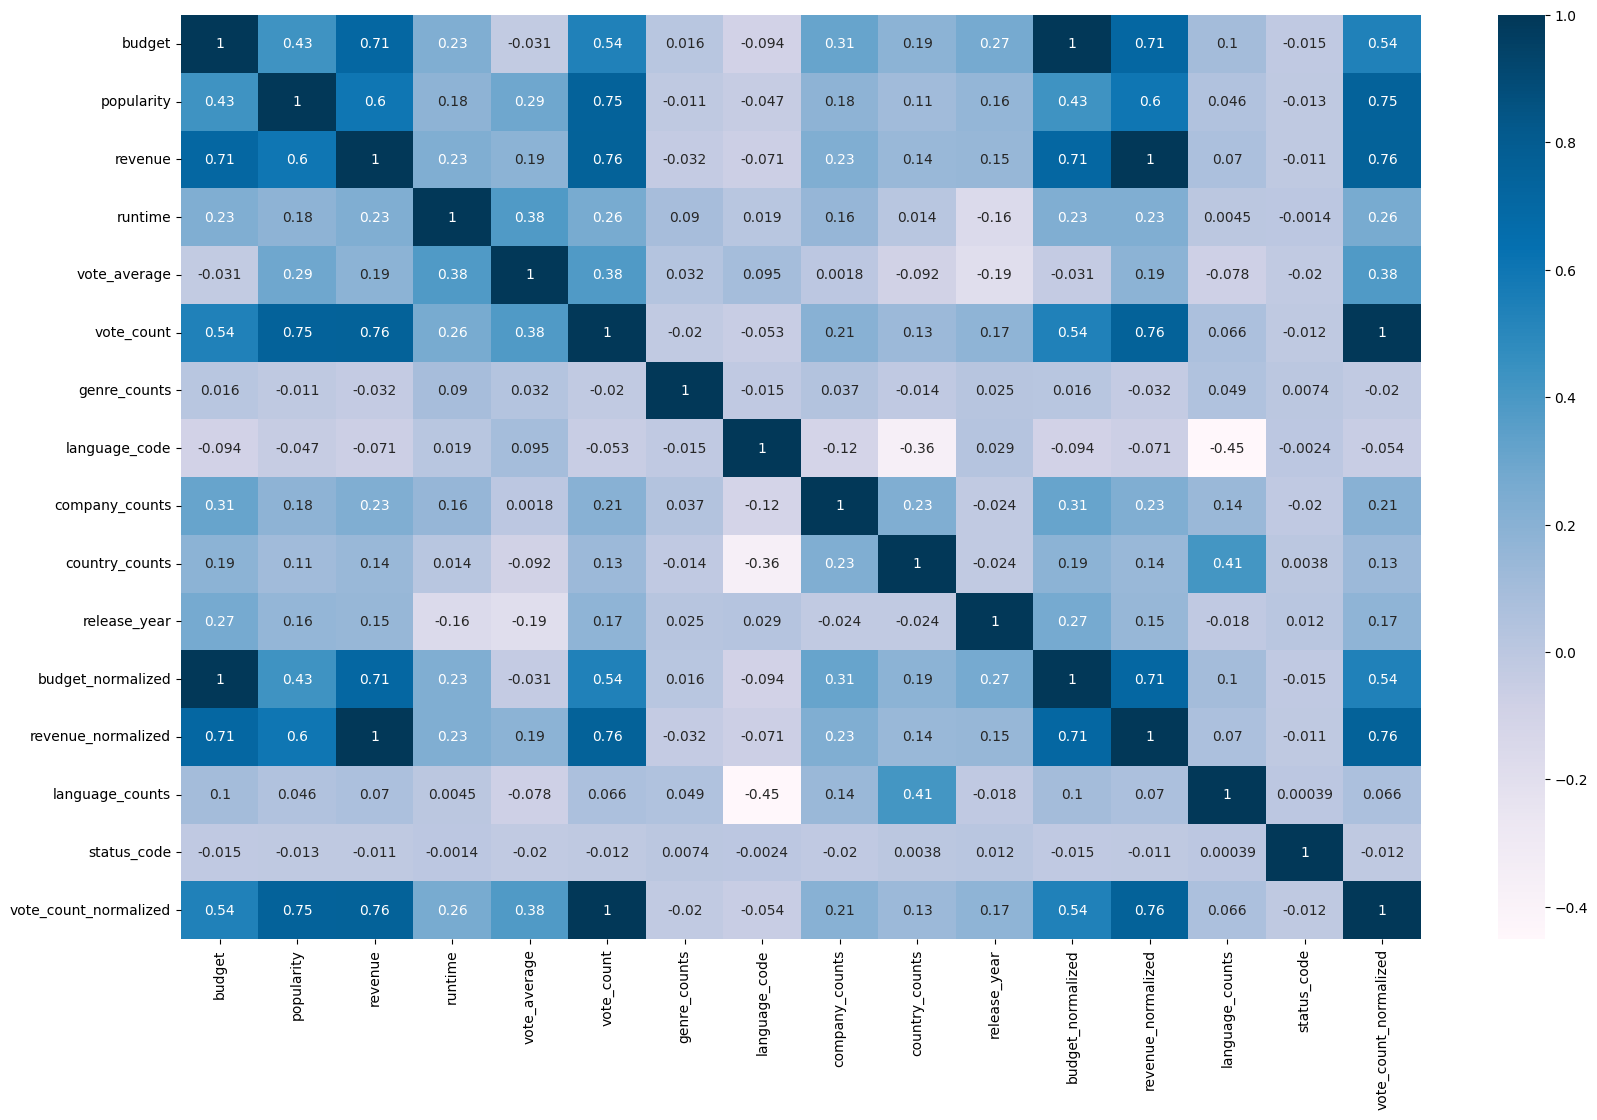

In [24]:
plt.figure(figsize=(20, 12))
sns.heatmap(movies_df.corr(), annot=True, cmap='PuBu')
plt.show()

**Histogram**

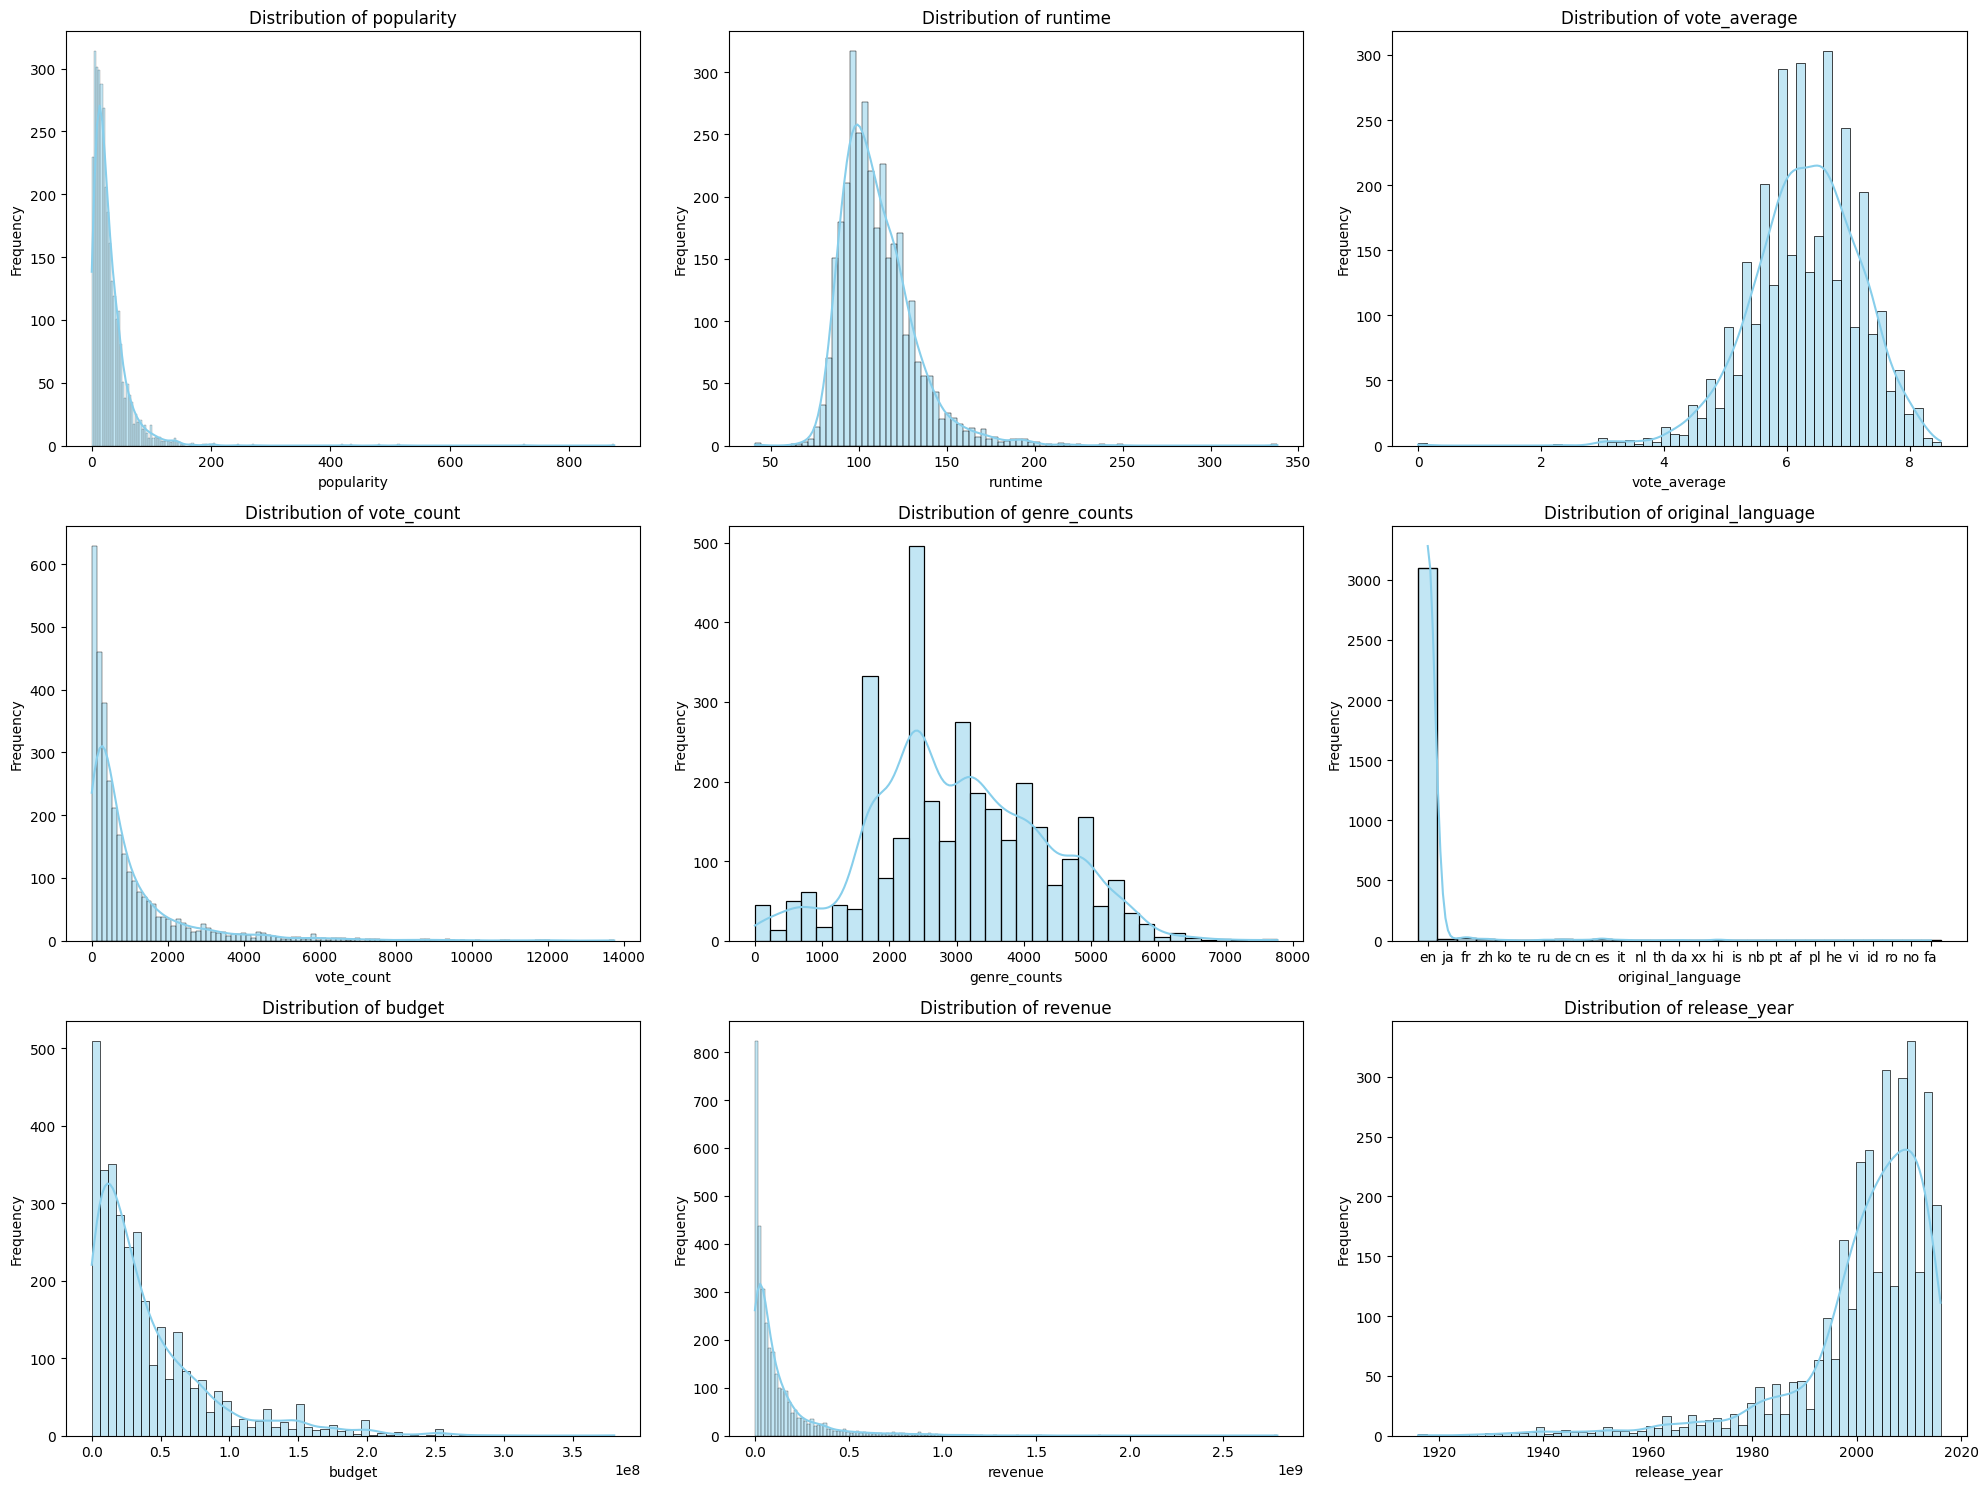

In [25]:
# Set up the figure and axes for subplots
fig, axs = plt.subplots(3, 3, figsize=(20, 15))
axs = axs.ravel()  # Flatten the 2D array of axes

# Plot histograms for each selected feature
for i, feature in enumerate([
    'popularity', 'runtime', 'vote_average', 'vote_count', 'genre_counts', 'original_language', \
    'budget','revenue', 'release_year'
]):
    sns.histplot(data=movies_df, x=feature, kde=True, ax=axs[i], color='skyblue')
    axs[i].set_title(f'Distribution of {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [26]:
movies_df.columns

Index(['budget', 'original_language', 'original_title', 'popularity',
       'revenue', 'runtime', 'vote_average', 'vote_count', 'genre_counts',
       'language_code', 'company_counts', 'country_counts', 'release_year',
       'budget_normalized', 'revenue_normalized', 'language_counts',
       'status_code', 'vote_count_normalized'],
      dtype='object')

In [27]:
print(movies_df['status_code'].unique())
print('------------------------')
print(movies_df['status_code'].value_counts())

[0 1]
------------------------
0    3228
1       1
Name: status_code, dtype: int64


In [28]:
# Find the infos of the row with status_code equal to 1
status_code_1_index = movies_df.index[movies_df['status_code'] == 1].tolist()

movies_df.loc[status_code_1_index]


,budget,original_language,original_title,popularity,revenue,runtime,vote_average,vote_count,genre_counts,language_code,company_counts,country_counts,release_year,budget_normalized,revenue_normalized,language_counts,status_code,vote_count_normalized
4178,2000000,en,Higher Ground,1.7,841733,109.0,5.3,14,3570,0,0,3956,2011,0.005,0.0,4485,1,0.001


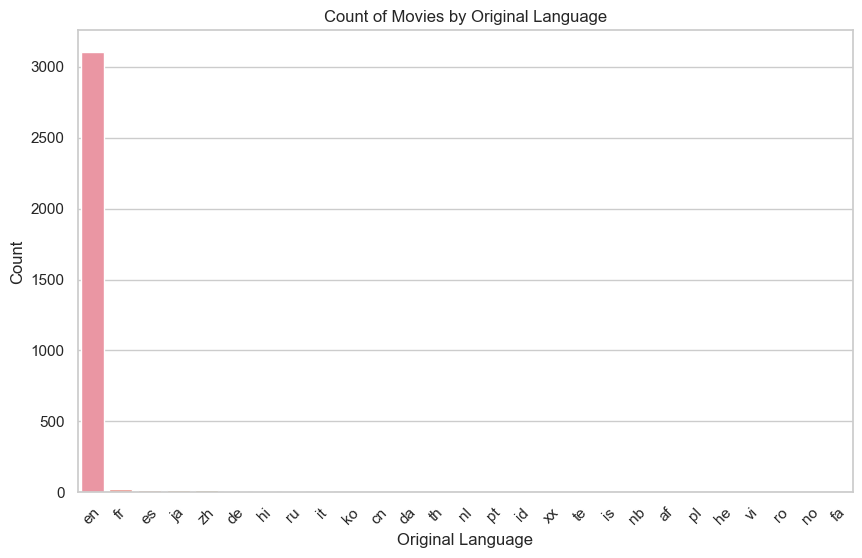

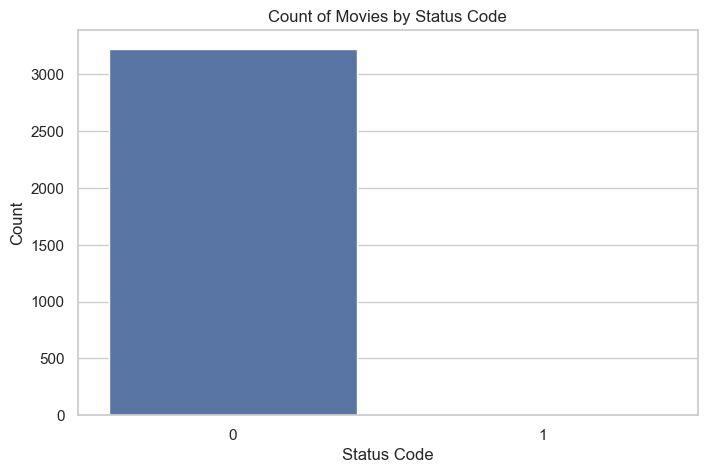

In [29]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.countplot(data=movies_df, x='original_language', order=movies_df['original_language'].value_counts().index)
plt.xlabel('Original Language')
plt.ylabel('Count')
plt.title('Count of Movies by Original Language')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(data=movies_df, x='status_code')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.title('Count of Movies by Status Code')
plt.show()


In [30]:
print(movies_df['original_language'].unique())
print('------------------------')
print(movies_df['original_language'].value_counts())

['en' 'ja' 'fr' 'zh' 'ko' 'te' 'ru' 'de' 'cn' 'es' 'it' 'nl' 'th' 'da'
 'xx' 'hi' 'is' 'nb' 'pt' 'af' 'pl' 'he' 'vi' 'id' 'ro' 'no' 'fa']
------------------------
en    3102
fr      25
es      15
ja      13
zh      13
de       9
hi       7
ru       6
it       6
ko       5
cn       5
da       4
th       2
nl       2
pt       2
id       2
xx       1
te       1
is       1
nb       1
af       1
pl       1
he       1
vi       1
ro       1
no       1
fa       1
Name: original_language, dtype: int64


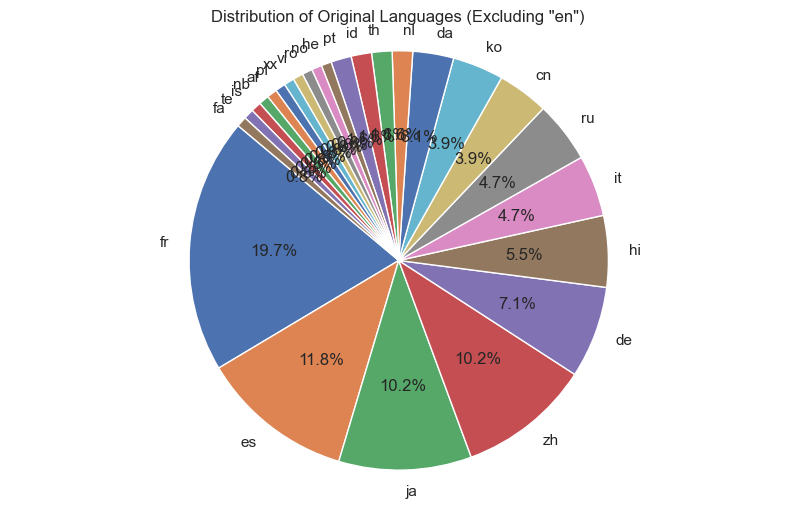

In [31]:
# Filter out 'en' language from the language counts
other_languages = movies_df[movies_df['original_language'] != 'en']['original_language'].value_counts()

# Create pie chart for original languages excluding 'en'
plt.figure(figsize=(10, 6))
plt.pie(other_languages, labels=other_languages.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Original Languages (Excluding "en")')
plt.axis('equal')
plt.show()


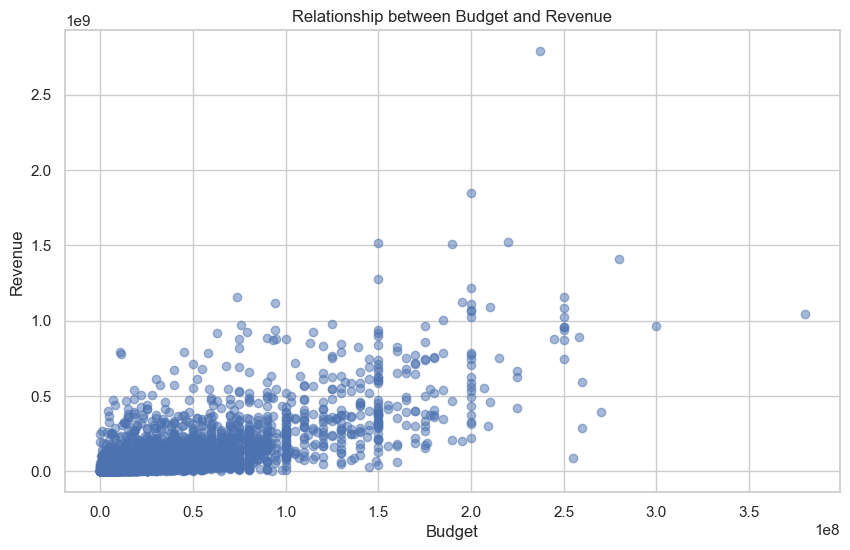

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(movies_df['budget'], movies_df['revenue'], alpha=0.5)
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.title('Relationship between Budget and Revenue')
plt.show()


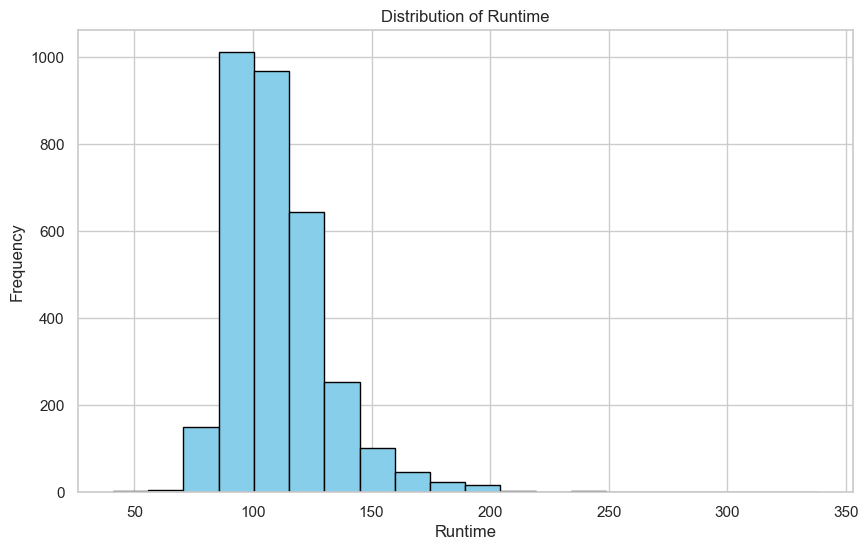

In [33]:
plt.figure(figsize=(10, 6))
plt.hist(movies_df['runtime'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Runtime')
plt.ylabel('Frequency')
plt.title('Distribution of Runtime')
plt.show()


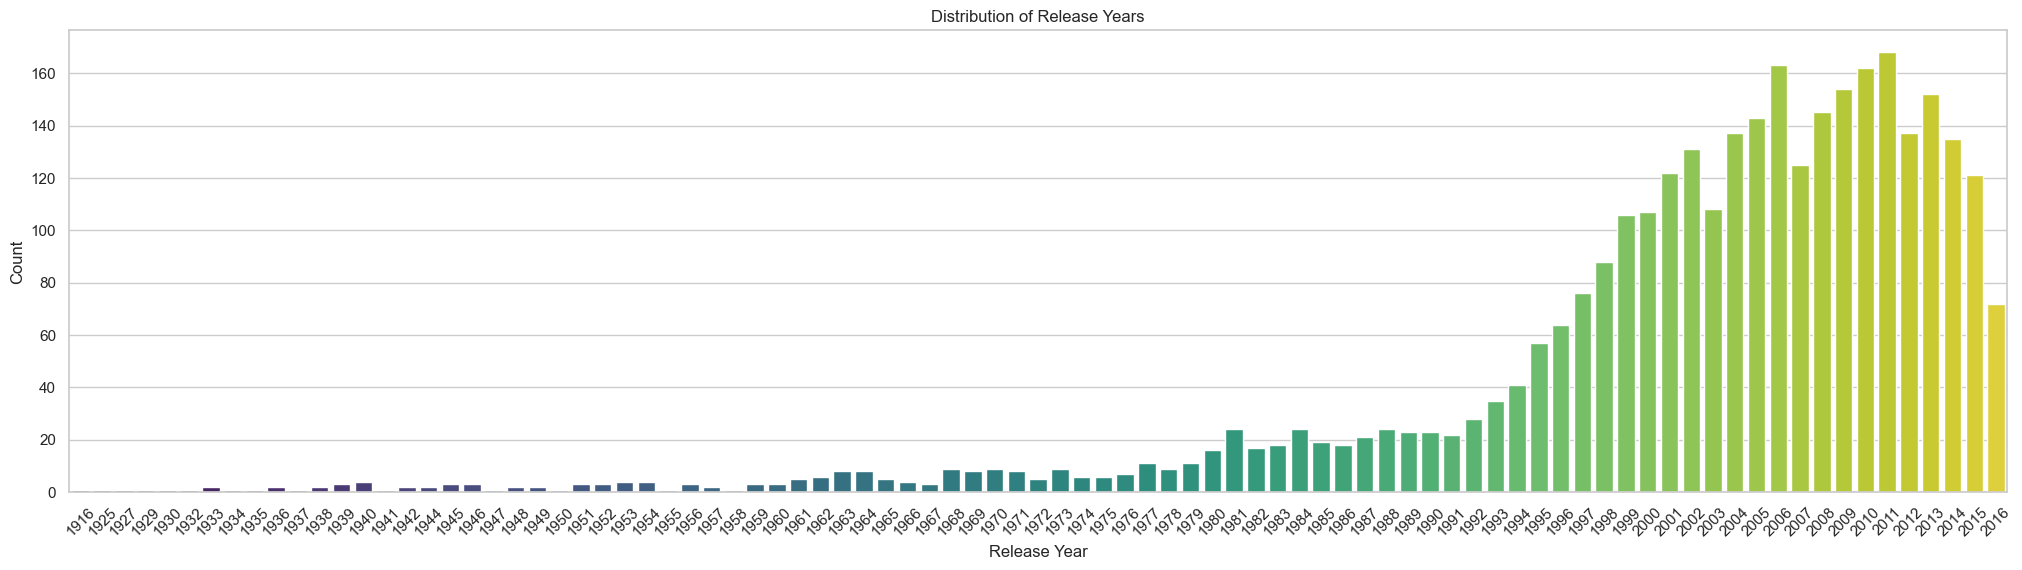

In [34]:
plt.figure(figsize=(25, 6))
sns.countplot(data=movies_df, x='release_year', palette='viridis')
plt.xlabel('Release Year')
plt.ylabel('Count')
plt.title('Distribution of Release Years')
plt.xticks(rotation=45)
plt.show()


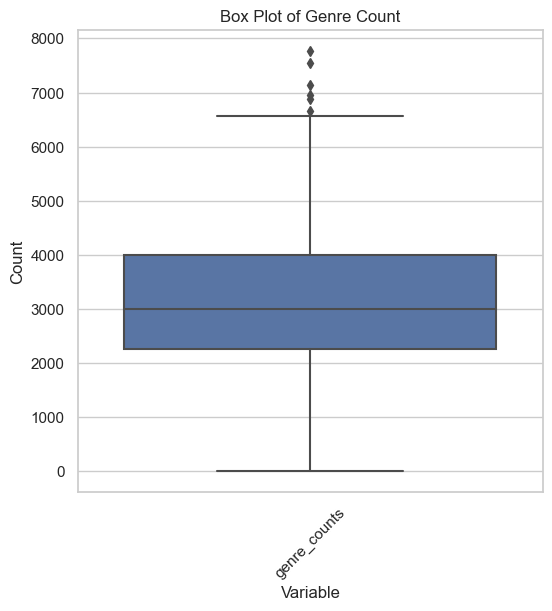

In [35]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=movies_df[['genre_counts']])
plt.xlabel('Variable')
plt.ylabel('Count')
plt.title('Box Plot of Genre Count')
plt.xticks(rotation=45)
plt.show()


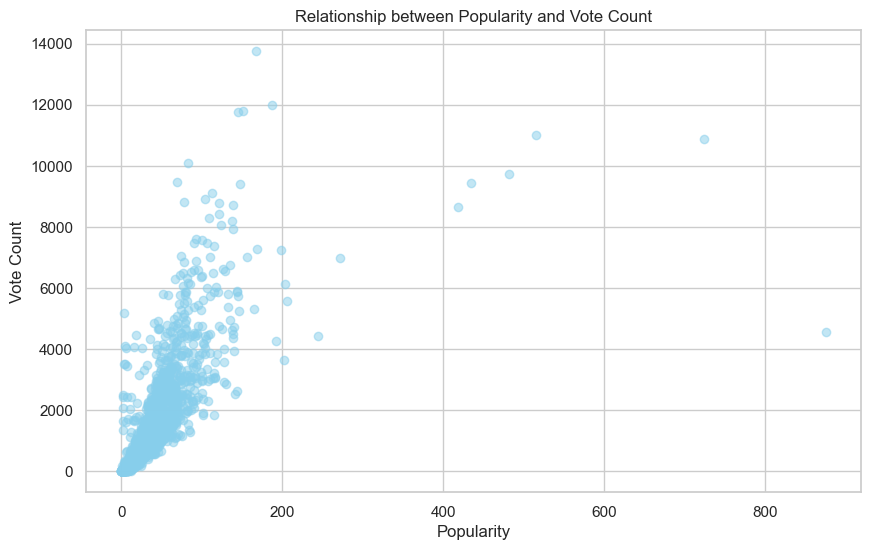

In [36]:
plt.figure(figsize=(10, 6))
plt.scatter(movies_df['popularity'], movies_df['vote_count'], alpha=0.5, color='skyblue')
plt.xlabel('Popularity')
plt.ylabel('Vote Count')
plt.title('Relationship between Popularity and Vote Count')
plt.show()


<a name='5'></a>

## 5. Data Modeling